In this section, you’ll build a network to classify Reuters newswires into **46 mutually
exclusive topics**. Because you have many classes, this problem is an instance of multi-
class classification; and because each data point should be classified into only one cate-
gory, the problem is more specifically an instance of `single-label, multiclass classification`.
If each data point could belong to multiple categories (in this case, topics), you’d be
facing a multilabel, multiclass classification problem.
3.5.1
#### The Reuters dataset
You’ll work with the Reuters dataset, a set of short newswires and their topics, published
by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There
are 46 different topics; some topics are more represented than others, but each topic
has at least 10 examples in the training set.

In [2]:
import keras
from keras.datasets import reuters

# the argument num_words=10000 restricts the data to the
#10,000 most frequently occurring words found in the data.
(train_data,train_labels),(test_data,test_labels)=reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 3s 1us/step


In [5]:
print(len(train_data))
print(len(test_data))

8982
2246


As with the IMDB reviews, each example is a `list of integers (word indices)`:

In [ ]:
#train_data[5]

Reverses it, mapping integer indices to words.
Decodes the review. Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”

In [ ]:
# Listing 3.13 Decoding newswires back to text
word_indx=reuters.get_word_index()
rev_word_indx=dict([(key,val) for (key,val) in word_indx.items()])
#print(rev_word_indx.get(10))
decoded_news = ' '.join([rev_word_indx.get(i - 3, 'we') for i in train_data[5]])
#print(decoded_news)

In [ ]:
# The label associated with an example is an integer between 0 and 45—a topic index:
train_labels[10]

#### Preparing the data

In [ ]:
train_data.shape

In [4]:
# Encode the data like the way below example 

#data="my name is jmajumde saying hello to the world"
data="hello world"
print(data)
alphabet='abcdefghijklmnopqrstuvwxyz '
int2char=dict((i,c) for i,c in enumerate(alphabet))
char2int=dict((c,i) for i,c in enumerate(alphabet))

print(char2int)
# integer encoded data
int_encoded=[char2int[char] for char in data]
print(int_encoded)

# now vectorize this
# to vectorize and use one-hot encoder our matrix dimention should be [27,27] per alphabet
import numpy as np
def vectorize_seq(sequences,dimen):
    np_arr=np.zeros((len(sequences),dimen))
    for i, sq in enumerate(sequences):
        np_arr[i,sq]=1
    return np_arr

print(vectorize_seq(int_encoded,len(alphabet))[2])

hello world
{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26}
[7, 4, 11, 11, 14, 26, 22, 14, 17, 11, 3]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


Similarly vectorize the train data

In [7]:
dimen=10000   # since we have restricted data to 10,000 frequently occurring words
x_train=vectorize_seq(train_data,dimen)
x_test=vectorize_seq(test_data,dimen)

To vectorize the labels, there are two possibilities: you can cast the `label list as an integer tensor`, or you can use `one-hot encoding`. 
One-hot encoding is a widely used for-mat for categorical data, also called categorical encoding. For a more detailed explanation of one-hot encoding, see section 6.1. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [15]:
# using one-hot encoding for labels
def one_hot(labels,dimen=46):
    res=np.zeros((len(labels),dimen))
    for i, lbl in enumerate(labels):
        res[i,lbl]=1
    return res

In [16]:
y_train=one_hot(train_labels)
y_test=one_hot(test_labels)

In [ ]:
# using integer tensor for label encoding
y_train=np.array(train_labels)
y_test=np.array(test_labels)


The only thing this approach would change is the choice of the loss function. The loss function used in listing 3.21, `categorical_crossentropy` , expects the labels to follow a `categorical encoding`. With integer labels, you should use `sparse_categorical_crossentropy` :

Using keras in-build library `to_categorical` to do one-hot encoding for labels

In [13]:
from keras.utils.np_utils import to_categorical
y_train=to_categorical(train_labels)
y_test=to_categorical(test_labels)

#### Model building

In [14]:
from keras import models
from keras import layers


In [20]:
print(x_train.shape)
print(x_train.shape[1:])

(8982, 10000)
(10000,)


The last layer uses a `softmax activation`. It means the network will output a probability distribution over the `46`
different output classes—for every input sample, the network will produce a `46-dimensional output vector`, where output[i] is the probability that the sample belongs to class i . The 46 scores will sum to 1.

In [21]:
# build a simple model first with two dense layers
model=models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=x_train.shape[1:]))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))  # last layers with 46 neurons, as the output label is 46



The best loss function to use in this case is `categorical_crossentropy` . It measures the distance between two probability distributions: here, between the probability distribution output by the network and the true distribution of the labels. By minimizing the distance between these two distributions, you train the network to output something as close as possible to the true labels.

In [43]:
#model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])


##### Validating 
Let’s set apart 1,000 samples in the training data to use as a validation set.

In [25]:
x_val=x_train[:1000]
x_train_partial=x_train[1000:]

y_val=y_train[:1000]
y_train_partial=y_train[1000:]


In [44]:
# Now, let’s train the network for 20 epochs.
history=model.fit(x_train_partial, y_train_partial,epochs=20,batch_size=25,
         validation_data=(x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 6s 772us/step - loss: 0.6501 - accuracy: 0.8533 - val_loss: 0.9453 - val_accuracy: 0.8180
Epoch 2/20
7982/7982 [==============================] - 5s 664us/step - loss: 0.4262 - accuracy: 0.9078 - val_loss: 0.9573 - val_accuracy: 0.8130
Epoch 3/20
7982/7982 [==============================] - 6s 782us/step - loss: 0.3173 - accuracy: 0.9318 - val_loss: 1.0602 - val_accuracy: 0.7970
Epoch 4/20
7982/7982 [==============================] - 7s 848us/step - loss: 0.2572 - accuracy: 0.9430 - val_loss: 1.0909 - val_accuracy: 0.8090
Epoch 5/20
7982/7982 [==============================] - 5s 677us/step - loss: 0.2267 - accuracy: 0.9493 - val_loss: 1.1437 - val_accuracy: 0.8080
Epoch 6/20
7982/7982 [==============================] - 5s 659us/step - loss: 0.2007 - accuracy: 0.9530 - val_loss: 1.2162 - val_accuracy: 0.7890
Epoch 7/20
7982/7982 [==============================] - 5s 638us/step - loss

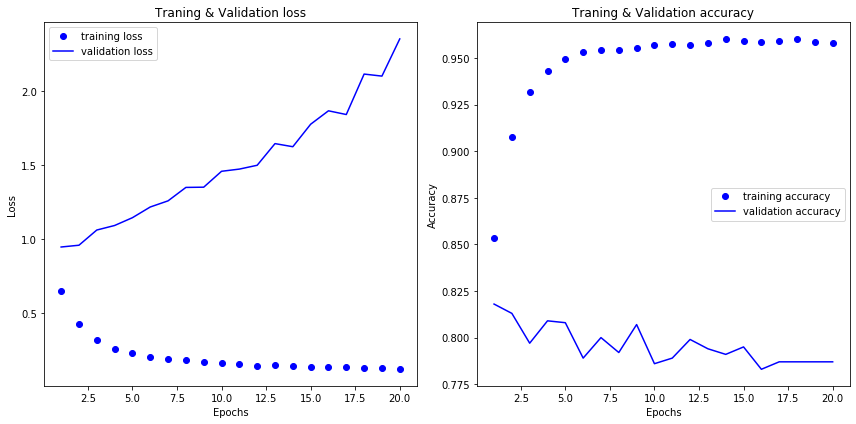

In [50]:
import matplotlib.pyplot as plt
def plot_train_vs_val(history,epochs=20):
    plt.figure(figsize=(12,6))
    
    # plot training v/s validation loss
    plt.subplot(1,2,1)
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs=range(1,len(loss)+1)
    plt.plot(epochs,loss,'bo',label='training loss')
    plt.plot(epochs,val_loss,'b',label='validation loss')
    plt.title('Traning & Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # plot training v/s validation accuracy
    plt.subplot(1,2,2)
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    plt.plot(epochs,acc,'bo',label='training accuracy')
    plt.plot(epochs,val_acc,'b',label='validation accuracy')
    plt.title('Traning & Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    #general    
    plt.tight_layout()
    plt.show()
    
    
plot_train_vs_val(history,20)
    
    

After 9/10 epochs validation accuracy start falling down and the validation loss steadily has upward trend. This is clear symbol of model overfits. So we need another model with lesser epochs say 9 may be .

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 257us/step - loss: 2.5903 - accuracy: 0.5040 - val_loss: 1.7247 - val_accuracy: 0.6320
Epoch 2/9
7982/7982 [==============================] - 2s 225us/step - loss: 1.3928 - accuracy: 0.7176 - val_loss: 1.2909 - val_accuracy: 0.7200
Epoch 3/9
7982/7982 [==============================] - 2s 218us/step - loss: 1.0324 - accuracy: 0.7815 - val_loss: 1.1353 - val_accuracy: 0.7510
Epoch 4/9
7982/7982 [==============================] - 1s 179us/step - loss: 0.8187 - accuracy: 0.8264 - val_loss: 1.0293 - val_accuracy: 0.7850
Epoch 5/9
7982/7982 [==============================] - 2s 211us/step - loss: 0.6496 - accuracy: 0.8673 - val_loss: 1.0017 - val_accuracy: 0.7820
Epoch 6/9
7982/7982 [==============================] - 2s 202us/step - loss: 0.5243 - accuracy: 0.8939 - val_loss: 0.9278 - val_accuracy: 0.8160
Epoch 7/9
7982/7982 [==============================] - 1s 154us/step - loss: 0.421

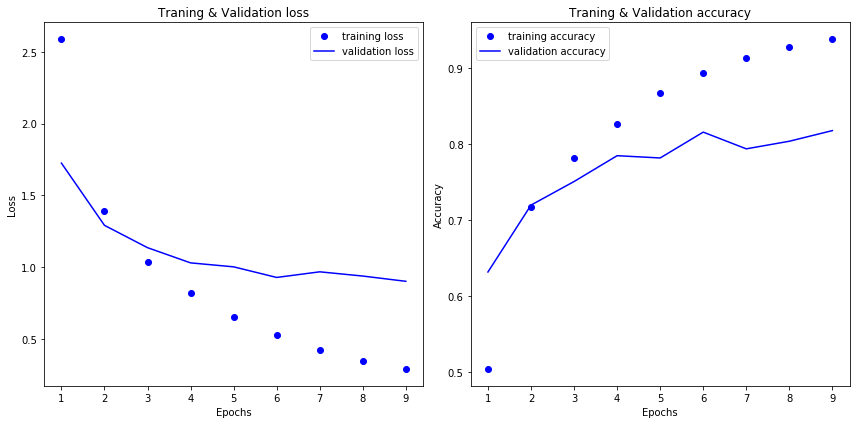

In [51]:
epochs=9
model=models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=x_train.shape[1:]))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

history=model.fit(x_train_partial, y_train_partial,epochs=epochs,batch_size=512,
         validation_data=(x_val,y_val))

plot_train_vs_val(history,epochs)

This is much better model compared to previous one, now we can evaluate the model against test data

In [52]:
res=model.evaluate(x_test,y_test)
res

2246/2246 [==============================] - 1s 259us/step


[0.9887019742947015, 0.7920747995376587]

This approach reaches an accuracy of `~80%`. With a `balanced binary classification` problem, the accuracy reached by a purely `random classifier would be 50%`. But in this case it’s closer to `19%`, so the results seem pretty good, at least when compared to a `random baseline`:

In [53]:
import copy
test_labels_cp=copy.copy(test_labels)
np.random.shuffle(test_labels_cp)
hits_arr=np.array(test_labels) == np.array(test_labels_cp)
float(np.sum(hits_arr)/len(test_labels))

0.1918967052537845

#### Generating predictions on new data


In [55]:
predictions=model.predict(x_test)
predictions.shape

(2246, 46)

In [57]:
# Each entry in predictions is a vector of length 46:
print("prediction vector length:", predictions[0].shape)

# The coefficients in this vector sum to 1:
print("The coefficients of vector sum: ", np.sum(predictions[0]))

# The largest entry is the predicted class—the class with the highest probability:
print("The highest probability class:", np.argmax(predictions[0]))

prediction vector length: (46,)
The coefficients of vector sum:  0.99999994
The highest probability class: 3


### Trying to use smaller dimension intermediate layers

because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 hidden units. Now let’s see what happens when you introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional: for example, 4-dimensional, 32 dimension

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 236us/step - loss: 3.3516 - accuracy: 0.3264 - val_loss: 2.8905 - val_accuracy: 0.3480
Epoch 2/9
7982/7982 [==============================] - 2s 224us/step - loss: 2.5913 - accuracy: 0.3673 - val_loss: 2.4325 - val_accuracy: 0.3830
Epoch 3/9
7982/7982 [==============================] - 2s 207us/step - loss: 2.2103 - accuracy: 0.3938 - val_loss: 2.2048 - val_accuracy: 0.3840
Epoch 4/9
7982/7982 [==============================] - 2s 246us/step - loss: 1.9729 - accuracy: 0.4204 - val_loss: 2.0361 - val_accuracy: 0.4100
Epoch 5/9
7982/7982 [==============================] - 2s 220us/step - loss: 1.7705 - accuracy: 0.4365 - val_loss: 1.8909 - val_accuracy: 0.4320
Epoch 6/9
7982/7982 [==============================] - 2s 221us/step - loss: 1.5503 - accuracy: 0.5916 - val_loss: 1.6821 - val_accuracy: 0.6100
Epoch 7/9
7982/7982 [==============================] - 1s 182us/step - loss: 1.318

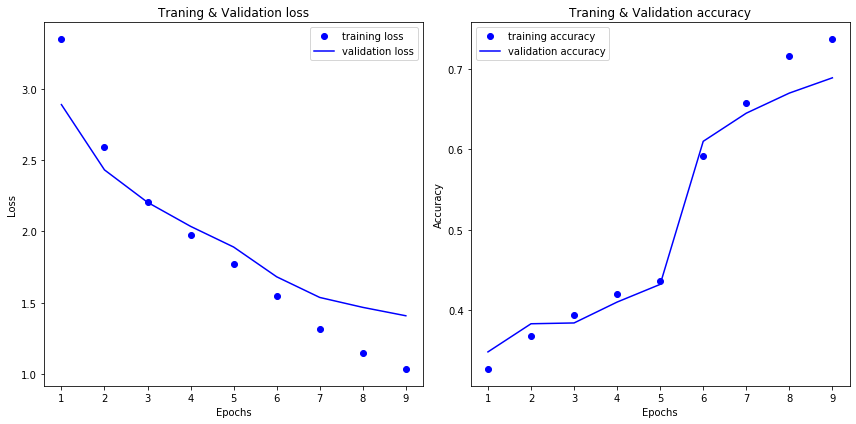

In [58]:
epochs=9
model=models.Sequential()
model.add(layers.Dense(64,activation='relu',input_shape=x_train.shape[1:]))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(4,activation='relu'))
model.add(layers.Dense(46,activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

history=model.fit(x_train_partial, y_train_partial,epochs=epochs,batch_size=512,
         validation_data=(x_val,y_val))

plot_train_vs_val(history,epochs)

The network now peaks at ~69% validation accuracy, an 11% absolute drop. This drop is mostly due to the fact that you’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional.